In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model as lm

In [36]:
buildings = pd.read_csv('Houses_Sold.csv')
buildings.dropna(axis=0, inplace=True)

In [37]:
bb_freq = buildings.loc[(buildings['house_size'] <= 5000),].groupby(['bed','bath']).size().reset_index(name='count')
bb_freq = bb_freq.loc[(bb_freq['bed']) > (bb_freq['bath'])]
max_beds = np.min(bb_freq.loc[(bb_freq['count'] == 1),]['bed'])-1
print(f'maximum bedrooms are {max_beds}')
# max_baths = np.max(bb_freq['bath'])
# print(f'maximum bathrooms are {max_baths}')

maximum bedrooms are 12.0


In [38]:
houses = buildings.loc[ (buildings['bed'] <= max_beds) & (buildings['bed'] > buildings['bath']) & (buildings['house_size'] <= 5000) & (buildings['house_size'] >= 1000) & (buildings['price'] > 1000) & (buildings['price'] < 10e6), ]
# houses = buildings.loc[(buildings['bed'] < 7) & (buildings['bath'] < buildings['bed']),]
houses_ar = np.array(houses.select_dtypes(include=np.number).iloc[:,1:])

PCA to reduce dimensions of housing dataframe

In [39]:
h_scaled = StandardScaler().fit_transform(houses_ar)
pca = PCA(n_components=2)
pca.fit(h_scaled)
h_PCs = pca.fit_transform(h_scaled)

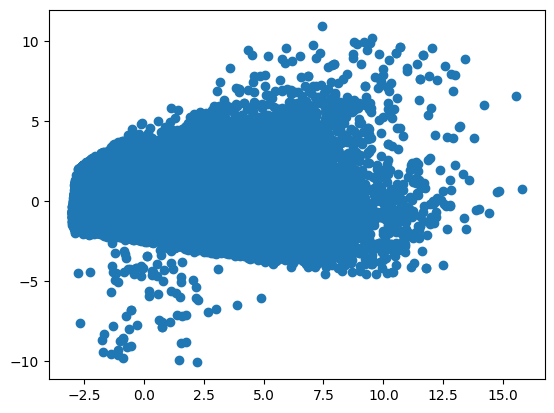

In [40]:
mask = h_PCs[:,0] < 10
plot_ar = h_PCs[mask]

fig, ax = plt.subplots()
ax.scatter(h_PCs[:,0], h_PCs[:,1])

C:\Users\ej_la\AppData\Local\Temp\ipykernel_7368\2721309593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  houses['size_bins'] = np.round(houses['house_size'],-2)


Text(0.5, 0.01, 'House Square Footage')

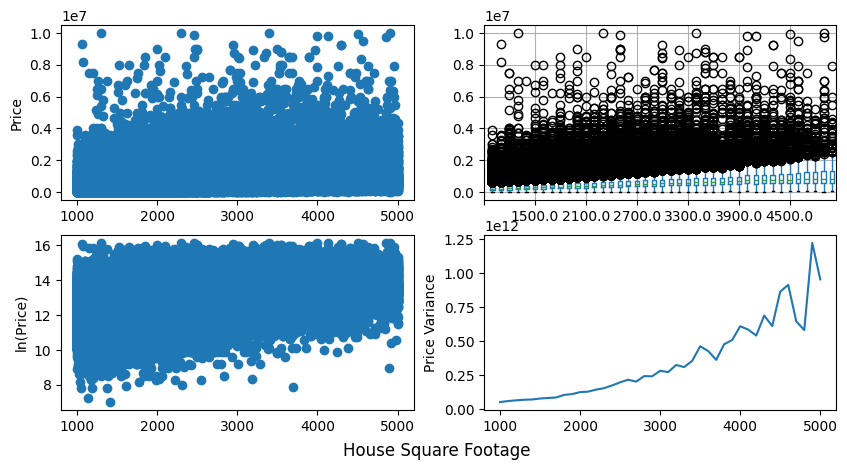

In [41]:
houses['size_bins'] = np.round(houses['house_size'],-2)
price_var = houses.groupby('size_bins')['price'].var().reset_index(name='price_var')
price_var = price_var.sort_values(by='size_bins')
price_by_bin = houses.groupby('size_bins')['price'].apply(list)
df_price_by_bin = pd.DataFrame({str(bin_label): pd.Series(vals)
                                for bin_label, vals in price_by_bin.items()})
sqft = list(price_by_bin.index)
price_ar = df_price_by_bin.to_numpy()

fig, ax = plt.subplots(2,2, figsize=(10,5))
ax[0,0].scatter(houses['house_size'], houses['price'])
ax[0,0].set_ylabel('Price')
df_price_by_bin.boxplot(ax=ax[0,1])
ax[0,1].set_xticks([i for i in range(0, len(sqft)) if (i % 6 == 0) or (i == 0) or (i == len(sqft))])
ax[1,0].scatter(houses['house_size'], np.log(houses['price']))
ax[1,0].set_ylabel('ln(Price)')
ax[1,1].plot(price_var['size_bins'], price_var['price_var'])
ax[1,1].set_ylabel('Price Variance')
fig.supxlabel('House Square Footage')

In [42]:
onehot_state = pd.get_dummies(houses['state'])
scale = StandardScaler()
scale.fit(np.array(houses[['house_size', 'acre_lot']]))
X = np.array(houses[['house_size', 'acre_lot']])
X = np.column_stack((X, onehot_state))
scale.fit(np.array(houses['price']).reshape(-1,1))
y = np.array(houses['price']).reshape(-1,1)

gamma = lm.GammaRegressor()
gamma.fit(X,y)
# gamma.score(X,y)

C:\Users\ej_la\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ej_la\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\ej_la\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_

GammaRegressor()

In [43]:
gamma.coef_

array([ 4.24490555e-04, -3.00097514e-06, -4.28338285e-03, -1.40774874e-05,
        3.71983758e-03, -3.29987079e-03,  1.17320080e-01,  1.73876772e-03,
       -9.36367584e-05, -1.02395527e-03,  1.40681193e-03,  6.05473806e-03,
       -1.10472256e-02,  2.39967078e-03,  1.47225752e-03, -1.13506483e-02,
       -2.53270721e-03, -4.33454526e-03, -3.43909753e-03, -4.67680753e-03,
       -3.72379998e-03, -5.05496976e-05, -2.20844722e-03,  6.42970096e-03,
       -6.07419471e-03, -8.18496893e-03, -1.31687731e-03, -7.25451397e-03,
        2.66695172e-04, -1.09611419e-03,  1.52785431e-03,  1.41980442e-06,
       -2.94039997e-04, -2.33458070e-03, -3.07939272e-03, -4.87224220e-03,
       -5.70925854e-04, -1.96843465e-02, -1.10488441e-02,  5.38427524e-03,
       -1.45780382e-02, -3.33676608e-05, -1.11553420e-04, -2.39014320e-03,
       -2.03681336e-04, -2.40323577e-03, -2.19754839e-02,  4.88074017e-04,
       -1.26607695e-04,  5.14523398e-07, -2.70005587e-03,  1.68375252e-02,
       -2.03668896e-03, -

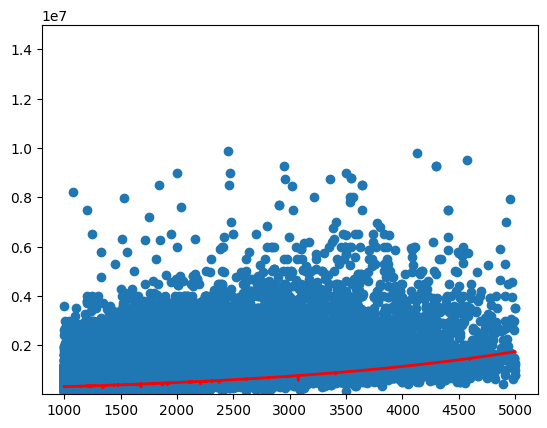

In [44]:
y_hat = gamma.predict(X)
mask = houses['state']=='California'
fig, ax = plt.subplots()
ax.scatter(houses.loc[mask,'house_size'], houses.loc[mask,'price'])
order = np.argsort(houses.loc[mask, 'house_size'])
ax.plot(houses.loc[mask,'house_size'].iloc[order], y_hat[mask][order], color='red', linewidth=2)
ax.set_ylim(0.001e7, 1.5e7)
plt.show()

In [45]:
disaster = pd.read_csv('NRI_Table_Counties.csv')
disaster['NRI_ID'] = disaster['NRI_ID'].astype(str).str.replace(r'^C', '', regex=True)
disaster['NRI_ID'] = pd.to_numeric(disaster['NRI_ID'], errors='coerce').astype('Int64')  # nullable integer dtype

check = disaster.loc[disaster['COUNTY'] == 'Fulton', :]

In [46]:
ZIPS = pd.read_csv('ZIP_COUNTY_062025.csv')

In [47]:
dis_zip_county = disaster.merge(ZIPS[['ZIP', 'COUNTY', 'USPS_ZIP_PREF_CITY']], how='left', left_on='NRI_ID', right_on='COUNTY')
# There are 11 records (all in Conneticut and American Somoa) that do not have county information after the merge
check = dis_zip_county.loc[dis_zip_county['ZIP'].isna(),:]

In [48]:
Complete_df = houses.merge(dis_zip_county, how='left', left_on='zip_code', right_on='ZIP')
check = Complete_df.loc[Complete_df['ZIP'].isna(),:]

In [49]:
Complete_df.shape[0]-check.shape[0]

930368

In [50]:
Income = pd.read_csv('22zpallagi.csv')

In [51]:
Income.loc[Income['zipcode']>0,].head()


,STATEFIPS,STATE,zipcode,agi_stub,N1,mars1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
6,1,AL,35004,1,1260.0,880.0,150.0,210.0,1170.0,50.0,...,0.0,0.0,130.0,129.0,990.0,2071.0,990.0,2055.0,0.0,0.0
7,1,AL,35004,2,1320.0,770.0,230.0,280.0,1230.0,40.0,...,0.0,0.0,270.0,289.0,1040.0,3257.0,1040.0,3240.0,30.0,32.0
8,1,AL,35004,3,1000.0,480.0,320.0,160.0,960.0,30.0,...,0.0,0.0,280.0,614.0,720.0,1733.0,720.0,1719.0,0.0,0.0
9,1,AL,35004,4,620.0,200.0,330.0,70.0,590.0,0.0,...,0.0,0.0,230.0,608.0,390.0,1107.0,380.0,1088.0,0.0,0.0
10,1,AL,35004,5,1040.0,130.0,860.0,50.0,980.0,30.0,...,0.0,0.0,470.0,1820.0,570.0,2101.0,560.0,2033.0,30.0,146.0


In [54]:
zip_pop = pd.read_csv('zip_pop.csv')
zip_pop[['zcta_code','zip_code']] = zip_pop['Geographic Area Name'].str.split(' ', n=1, expand = True)
zip_pop['zip_code'] = pd.to_numeric(zip_pop['zip_code'], errors='coerce').astype('Int64')  # nullable integer dtype

In [55]:
house_pop = houses.merge(zip_pop[['zip_code',' Total Population']], how='left', on='zip_code')

In [57]:
check = house_pop[['zip_code',' Total Population', 'price']]

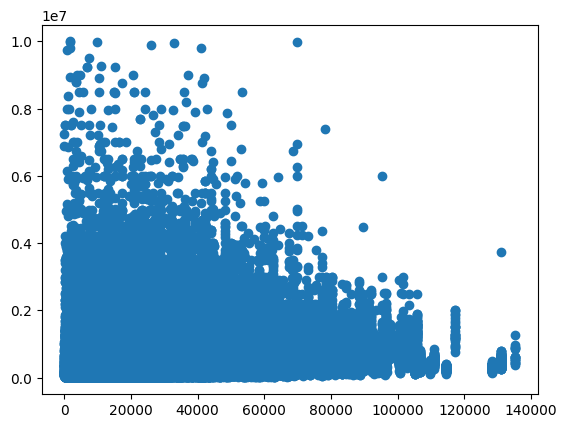

In [56]:
fig, ax = plt.subplots()
ax.scatter(house_pop[' Total Population'], house_pop['price'])
plt.show()